# Bird Image Classification
This file contains a classifcation problem on a dataset of RGB images of $499$ different species of birds. The primary method for classification is the convolutional neural network. We first start to prepare and explore our data. Then, we will explain so of the layers as we construct our model under the TensorFlow platform, and then go in depth into standard practices to parameterize, tune, and analyze the neural network model. Additionally, we will implement other models in order to classify the images by bird species and compare results, efficiency, and interpetability.

### Importing all the packages we need.
It's hard to know beforehand exactly all the packages you need. We consolidate all the import commands here for the sake of consistency, brevity later on, and so others know exactly where to look for specific libraries or packages imported.

In [4]:
#numerical and basic data science packages
import pandas as pd
import numpy as np
import math

# directory and data management
import os
from pathlib import Path

# scikit learn data science packages
from sklearn.model_selection import train_test_split
from scipy import misc
from sklearn import metrics

# image processing
import PIL

# tensorflow and keras
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Activation
from tensorflow.keras.layers import Flatten, Resizing, Rescaling, BatchNormalization, RandomFlip, RandomRotation
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#data visualizaiton
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

Code below is only necessary if accessing directories through google drive while using Google Colab.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Code below lists all files in directory

In [6]:
#os.listdir('/content/drive/MyDrive/nnprojectfolder/nnproject/train')

Here, I stored as variables the file path of the datasets. For the full dataset, run the first cell. Otherwise, run the second. Note: This will be entirely different for your own implementation as this depends on how you store and import the datasets.

In [13]:
#TRAIN_DIR = '/content/drive/MyDrive/nnprojectfolder/515_birds/nnproject/train'
#VALID_DIR = '/content/drive/MyDrive/nnprojectfolder/515_birds/nnproject/valid'
#TEST_DIR = '/content/drive/MyDrive/nnprojectfolder/515_birds/nnproject/test'

In [14]:
TRAIN_DIR = '/content/drive/MyDrive/nnprojectfolder/nnproject/train'
VALID_DIR = '/content/drive/MyDrive/nnprojectfolder/nnproject/valid'
TEST_DIR = '/content/drive/MyDrive/nnprojectfolder/nnproject/test'

Here we set variables to store the size of the batch size, image height, width, and depth (also referred to as channels). Note that our image height and width are $224$. This is because any pretrained model is fit to images of size $224$ and also, the smallest image in our data set is $224\times 224$, so we simple crop any image that is $256\times 256$ to $224\times 224$.

In [8]:
batch_size = 32
img_height = 224
img_width = 224
img_depth = 3

Here, we load our data using Keras. In order to load these images off drive, we use the `tf.keras.utils.image_dataset_from_directory` utility. This takes us from a directory of images on our drive to a `tf.data.Dataset` in just a couple lines of code.

Loading the train dataset. When `label_mode='categorical'`, this is one hot encoding.

In [36]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    interpolation='nearest',
    crop_to_aspect_ratio=False,
    shuffle=True,
    seed=0,
)

x = next(iter(train_ds.take(1)))
print(f"The shape of a batch of data is: {x[0].get_shape()}")

train_batches = train_ds.cardinality().numpy()
print(train_batches)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names[:10])
print(num_classes)

print(f"There are in total {num_classes} different classes/bird names")
print(f"The number batches in the training dataset: {train_batches}")

Found 15829 files belonging to 100 classes.
The shape of a batch of data is: (32, 224, 224, 3)
495
['AFRICAN EMERALD CUCKOO', 'ALBATROSS', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'ANNAS HUMMINGBIRD', 'AZURE JAY', 'AZURE TIT', 'BALD EAGLE', 'BALTIMORE ORIOLE', 'BARN OWL']
100
There are in total 100 different classes/bird names
The number batches in the training dataset: 495


Note: Where it says `tf.Tensor(495, shape=(), dtype=int64)`, this is because we have $15,824$ images and since each batch has $32$ images, we have $\frac{15,824}{32} = 494.5$ so we have a total of $495$ batches. Each batch of shape $(32, 224, 224, 3)$. This number will serve as the total number of steps per epoch. This is because when performing our optimization, if we are utilizing a batch of size $32$ for each adjustment to our parameters when utilizing stochastic gradient descent, we need to do enough steps of back propogation in order to get a reasonable estimation for an accurate calcuation to reach a minima.

When importing the full dataset we get $2,586$ batches.

The data type of our datasets are `tf.data.Dataset`. Similar to a `DataFrame` in Pandas, we can access features of samples of data very quickly. Here we showcase this by naming of a few of the bird species which lie under the feature name `class_names`.

In [15]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    interpolation='nearest',
    crop_to_aspect_ratio=False,
    shuffle=False,
    seed=0,
)

x = next(iter(valid_ds.take(1)))
print(f"The shape of a batch of data is: {x[0].get_shape()}")
print(valid_ds.cardinality())

Found 500 files belonging to 100 classes.
The shape of a batch of data is: (32, 224, 224, 3)
tf.Tensor(16, shape=(), dtype=int64)


In [18]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    interpolation='nearest',
    crop_to_aspect_ratio=False,
    shuffle=False,
    seed=0,
)

x = next(iter(test_ds.take(1)))
print(f"The shape of a batch of data is: {x[0].get_shape()}")
print(test_ds.cardinality())

Found 500 files belonging to 100 classes.
The shape of a batch of data is: (32, 224, 224, 3)
tf.Tensor(16, shape=(), dtype=int64)


In [21]:
test_batches, valid_batches = test_ds.cardinality().numpy(), valid_ds.cardinality().numpy()
print(f"The number batches in the test and validation datasets: {test_batches, valid_batches}")

The number batches in the test and validation datasets: (16, 16)


***

Here are 2 samples of data. In other words, two colored JPG images. I chose first the Peregrine Falcon since it is an astonishingly magnificent bird and has a lot of cool facts about. Second, the Shoebill Stork since it is the "Sigma" bird in meme culture and it is remarkably distinguishable from other birds. Qualitatively, just by looking at it, we would expect the Shoebill to have a high test accuracy since it seems to be so distinct from most other images of birds. We will come back to this image later on to see our results.

The shape of this image is (height, width, channels):  (224, 224, 3)


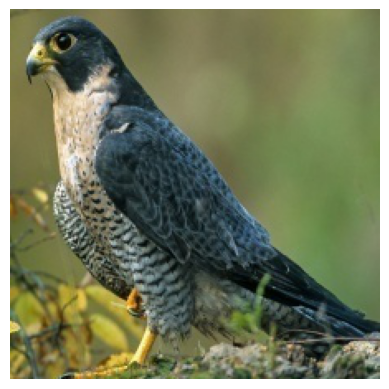

In [23]:
P_FALCON = load_img(TRAIN_DIR + '/PEREGRINE FALCON/052.jpg')
plt.imshow(P_FALCON)
plt.axis("off")

image_arr1 = img_to_array(P_FALCON)
IMG_SHAPE = image_arr1.shape # set IMG_SHAPE to constant tuple for later use in file

print('The shape of this image is (height, width, channels): ', IMG_SHAPE)
#plt.savefig('peregrine_falcon')

#### Peregrine Falcon:
From Wikipedia: "The peregrine falcon (Falco peregrinus), also known as the peregrine, and historically as the duck hawk in North America, is a cosmopolitan bird of prey (raptor) in the family Falconidae. A large, crow-sized falcon, it has a blue-grey back, barred white underparts, and a black head. The peregrine is renowned for its speed, reaching over 320 km/h (200 mph) during its characteristic hunting stoop (high-speed dive), making it the fastest bird in the world, as well as the fastest member of the animal kingdom." [Peregrine Falcon](https://en.wikipedia.org/wiki/Peregrine_falcon)

The name "peregrine" means wanderer. Despite the fact that the species of bird lives anywhere from the North to South pole and many places in between including the tropics, it is quite rare to see one yourself. There are many videos and short documentaries on this species of bird which I suggest looking up yourself if you'd like to see it in action.

The shape of this image is (height, width, channels):  (224, 224, 3)


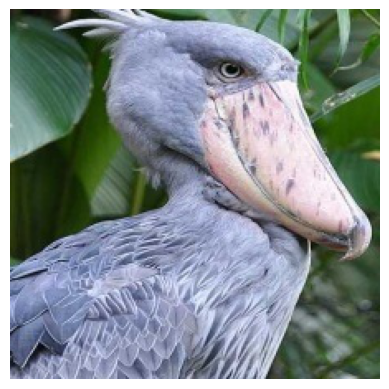

In [25]:
SIGMA_BIRD = load_img(TEST_DIR + '/SHOEBILL/5.jpg')
plt.imshow(SIGMA_BIRD)
plt.axis("off")

image_arr2 = img_to_array(SIGMA_BIRD)
print('The shape of this image is (height, width, channels): ', image_arr2.shape)
#plt.savefig('sigma_bird')

#### Shoebill:
From Wikipedia: "The shoebill (Balaeniceps rex) also known as the whalebill, whale-headed stork or shoe-billed stork, is a very large long-legged wading bird. It derives its name from its enormous shoe-shaped bill. It has a somewhat stork-like overall form and has previously been classified with the storks in the order Ciconiiformes based on this morphology. However, genetic evidence places it with pelicans and herons in the Pelecaniformes. The adult is mainly grey while the juveniles are more brown. It lives in tropical East Africa in large swamps from South Sudan to Zambia." [Shoebill](https://en.wikipedia.org/wiki/Shoebill)

The Shoebill makes a really crazy sound with its bill. It apparently does this for attracting mates. Here is a video of it taken at the Japan Matsue Vogel Park/Zoo: [Shoebill Clattering Sounds](https://www.youtube.com/watch?v=kDMHHw8JqLE)

Here I display the pixel values of each (224, 224) matrix in an image in their corresponding channel/color.

In [26]:
rgb_img = np.asarray(SIGMA_BIRD)
x,y,z = np.shape(rgb_img)
red = np.zeros((x,y,z),dtype=int)
green = np.zeros((x,y,z),dtype=int)
blue = np.zeros((x,y,z),dtype=int)
for i in range(0,x):
    for j in range(0,y):
        red[i][j][0] = rgb_img[i][j][0]
        green[i][j][1]= rgb_img[i][j][1]
        blue[i][j][2] = rgb_img[i][j][2]

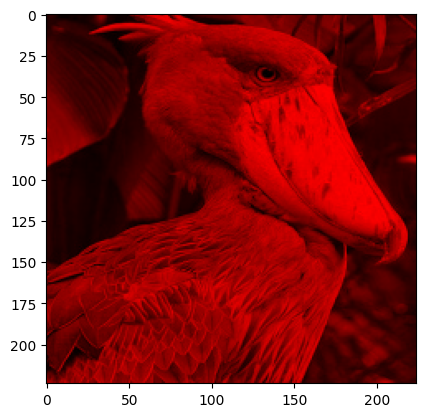

In [27]:
plt.imshow(red)
plt.show()

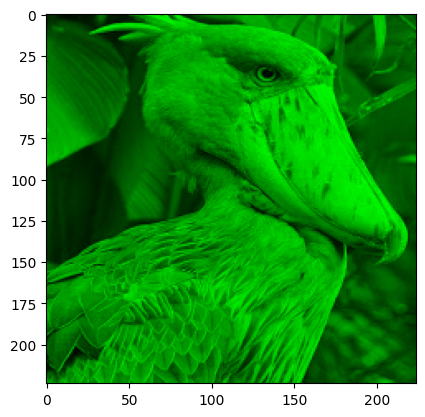

In [28]:
plt.imshow(green)
plt.show()

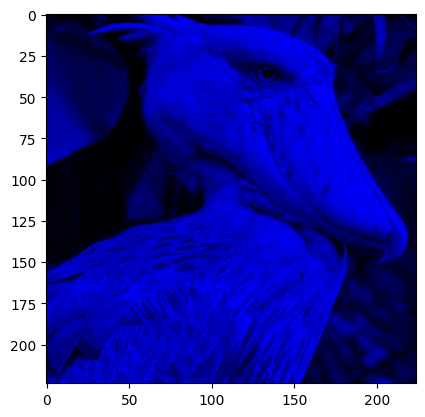

In [29]:
plt.imshow(blue)
plt.show()

Here is an example of a Gaussian Convolution, otherwise known as a Gaussian blur.

The shape of this image is (height, width, channels):  (224, 224, 3)


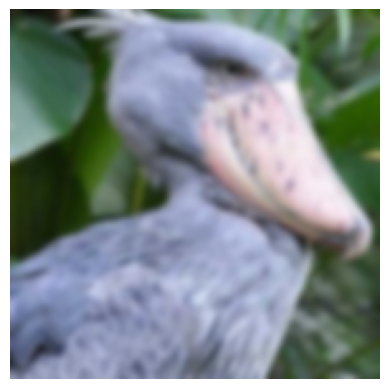

In [30]:
SIGMA_BIRD = SIGMA_BIRD.filter(filter=PIL.ImageFilter.GaussianBlur(radius=2))
plt.imshow(SIGMA_BIRD)
plt.axis("off")

image_arr = img_to_array(SIGMA_BIRD)
print('The shape of this image is (height, width, channels): ', image_arr.shape)

Below is a random sample of the data. Why is it random? Note that when we created the paths to our image datasets, we had `shuffle=True` for the training data. For the validation and test sets we opted to have shuffle set to `False`.

Here are 12 maginficent birds and their corresponding class labels.

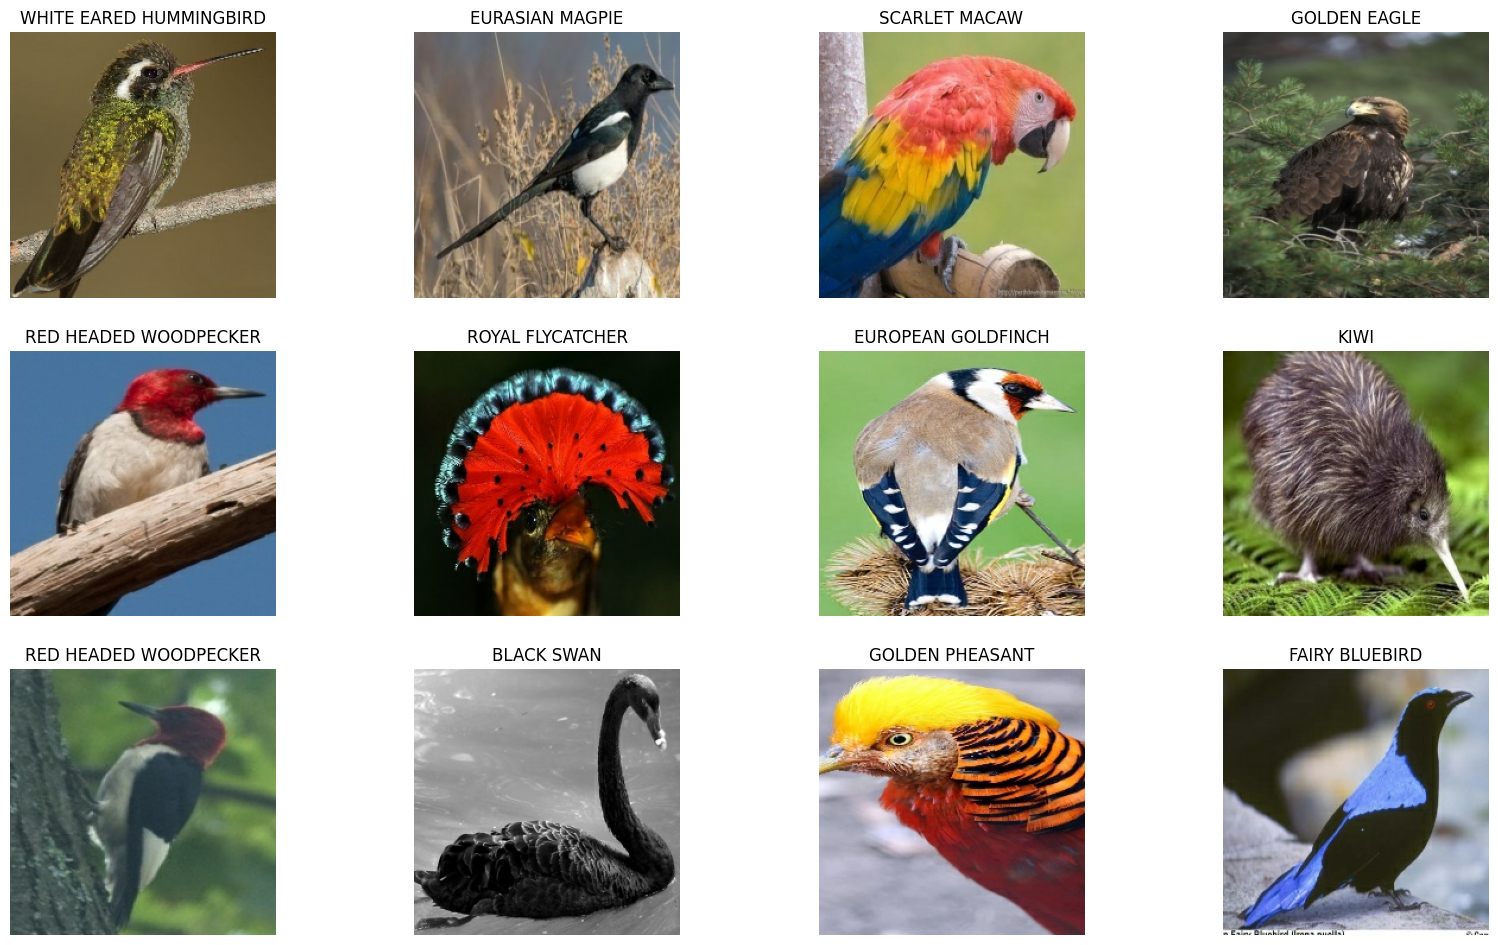

In [43]:
plt.figure(figsize=(20, 20))
# The take() method returns the specified rows from the DataFrame. 
# The take() method needs the row positions, even if the rows has named indexes.
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        idx = np.where(labels[i] == 1)[0][0]
        plt.title(class_names[idx])
        plt.axis("off")

You may notice that some of the images have watermarks on them. We essentially ignore these since the images are for the most part preprocessed quite well for our intents and purposes. We may also notice the large variety of types of "shots". For every bird there are many distinct images that can be produced. Such as a stand still of its head or a picture from above of the bird in flight. Each image has the bird centered and focused with reasonable contrast and brightness, so we hope to see the convolutional neural network be able to detect features of these birds from multiple types of shots, invariant to tranlsations, and classify the bird correctly.

Here, we plot a distribution of each bird's frequency in our data set. 

In [44]:
image_dir = Path('/content/drive/MyDrive/nnprojectfolder/nnproject/train')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
print(image_df.size)

31658


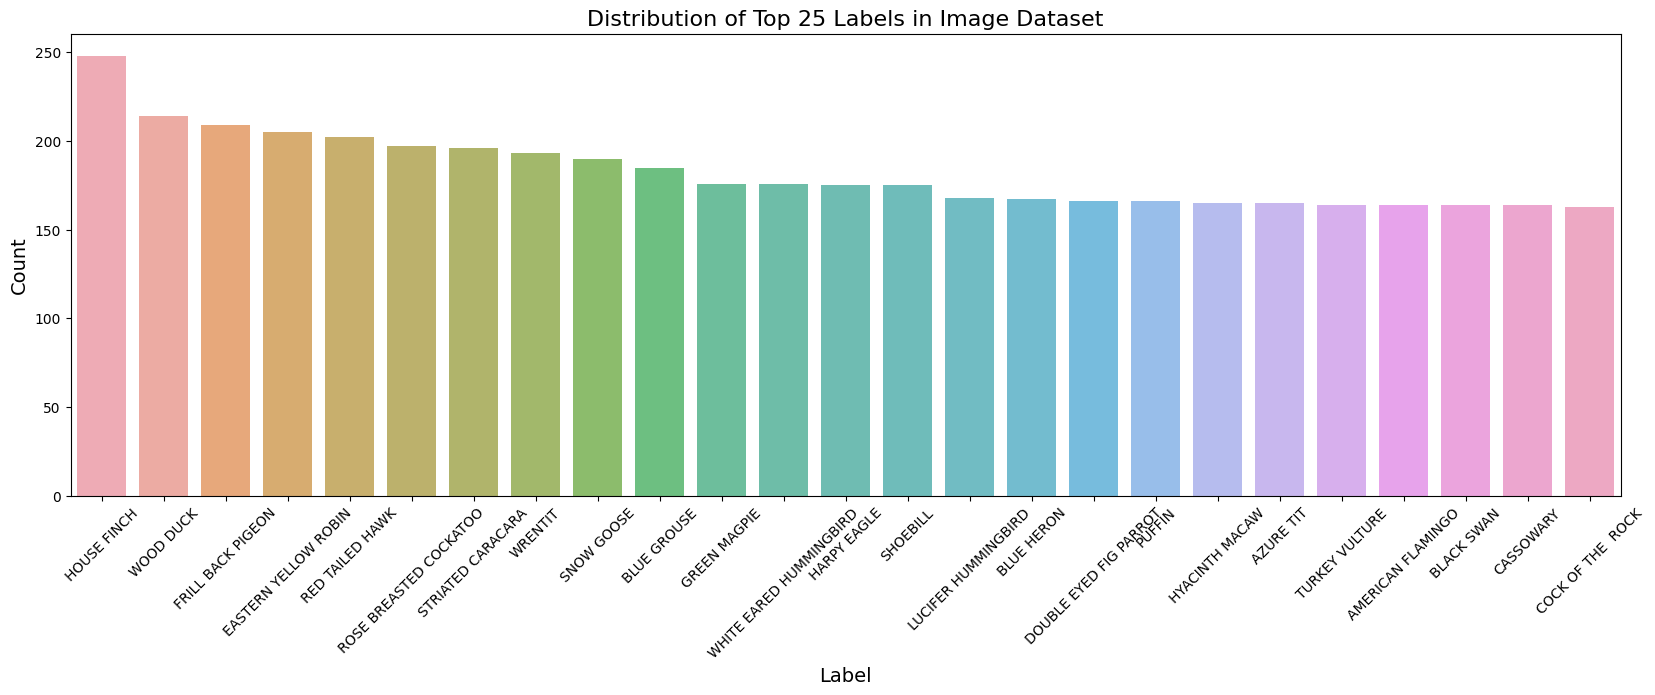

In [45]:
label_counts = image_df['Label'].value_counts()[:25]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8)
plt.title('Distribution of Top 25 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45) 
plt.savefig('top_25_image_counts', bbox_inches="tight")
plt.show()

Here is the last $25$ most common labels in our data set.

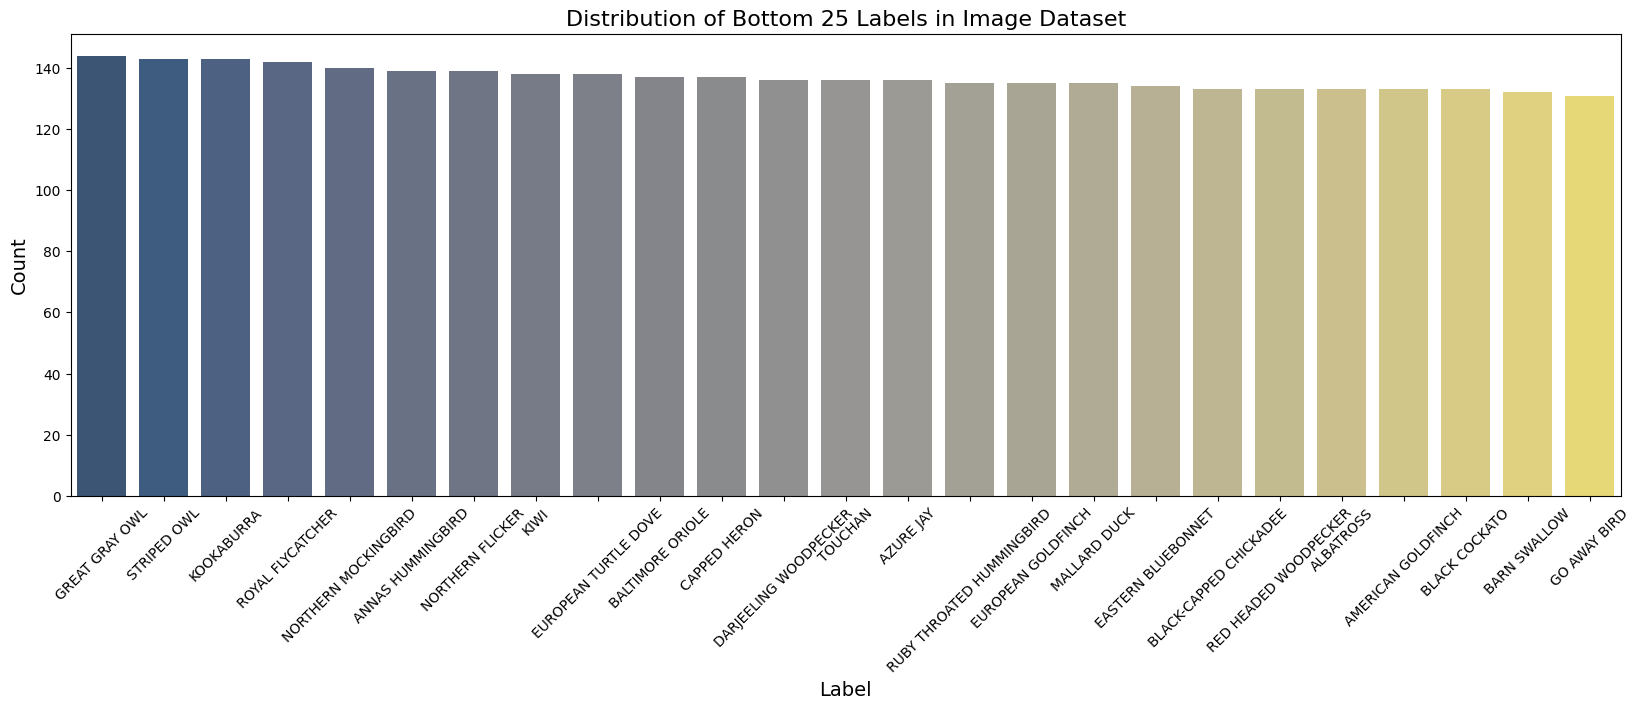

In [47]:
label_counts = image_df['Label'].value_counts()[-25:]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='cividis')
plt.title('Distribution of Bottom 25 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45) 
plt.savefig('bottom_25_image_counts', bbox_inches="tight")
plt.show()

Here is all of them. We omit the labels on the x-axis to avoid clutter.

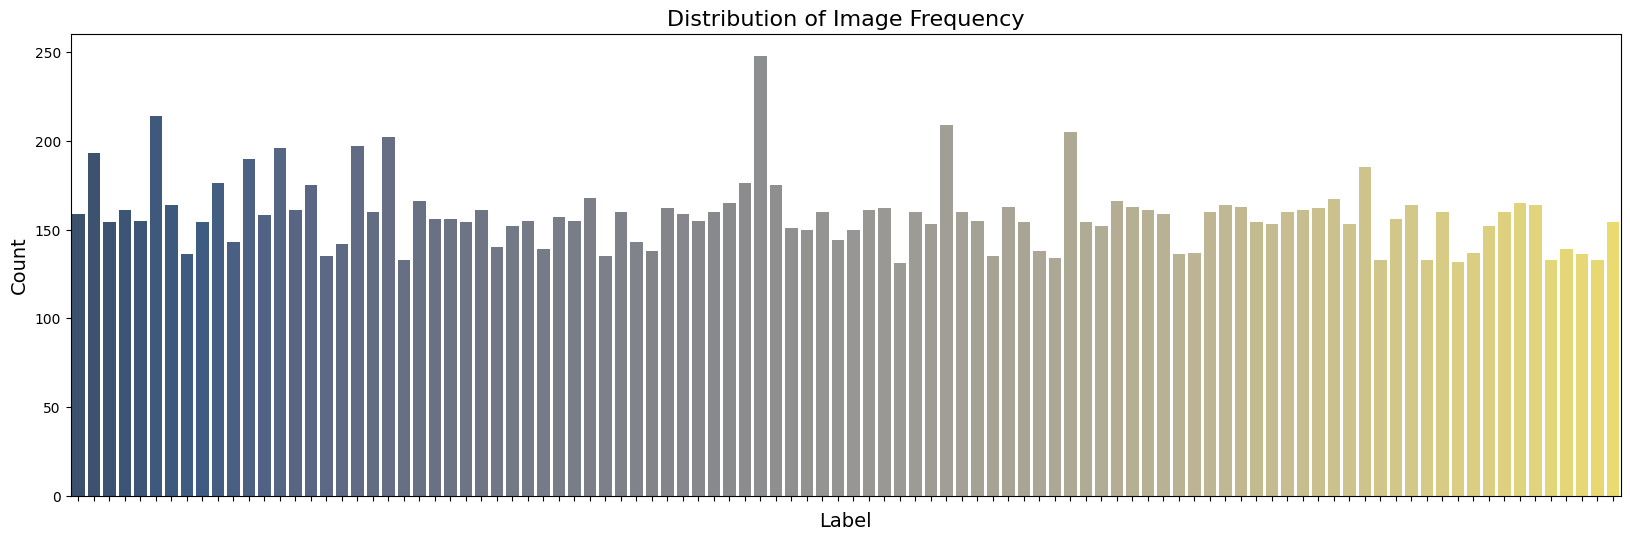

In [48]:
label_counts = image_df['Label'].value_counts(sort=False)

plt.figure(figsize=(20, 6))
bp = sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='cividis')
bp.set(xticklabels=[]) 
plt.title('Distribution of Image Frequency', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.savefig('image_count_distribution', bbox_inches="tight")
plt.show()

Thinking about our data a little further, in order to understand how our classification models work, we need quickly make sure that we understand our data before we move on. At its fundamental level, each data point is an 8-bit integer representing the brightness of a pixel. The position of the data point in our dataset determines where in the image the pixel resides and whether the pixel is red or green or blue. 

### Batch Normalization
Notice that each numerical value in the tensor for an image batch is a number in the interval $[0, 255]$. From Machine Learning Mastery: "Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1."

Generally, rescaling the data into the interval $[0,1]$ is good practice and avoids unnecessary numerical round off that can result in slower training and increased error.

Our method for rescaling is taken from the TensorFlow tutorial on image classifcation at the url: https://www.tensorflow.org/tutorials/images/classification

In [50]:
normalization_layer = Rescaling(1./255)
train_ds_sparse = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))

Note: Don't run these more than once. They are recursive assignments so if you do it will make it orders of magnitude smaller each time!

### Data Augmentation:
Here is a definition of data augmentation from TensorFlow:

Data augmentation: "A technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation." [TensorFlow: Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)

Data augmentation consists of techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.

In [51]:
# Data Augmentation Step
data_augment = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
])

***

## Implementations on subset dataset:

### Building our Models
#### Our Models:
7 Layer CNN: A seven layer convolution neural network we made utilizing some standard practices and ideas gathered from various sources and the textbook "An Introduction To Statistical Learning" by Hastie et. al.

VGG 16 + FC-Layer: A transfer learning model utilizing the pretrained VGG16 model and one added fully connected layer of width $512$.

ResNet50 + FC-Layer: A transfer learning model utilizing the pretrained ResNet50 model and one added fully connected layer of width $512$.

#### 7-Layer CNN

This model vaguely follows the architecture described by the book "An Introduction to Statistical Learning" by Hastie et al. Below we will summarize in words the key components and layers of this specific convolutional neural network.

What we refer to as a layer here is simply just an added layer to the actual `Sequential` instance named `model1`. However, in practice we may refer to several layers as just one layer. Typically, we ignore layers that are not convolution or fully connected layers. We title this CNN a 7-Layer CNN using that logic. In some cases, people will group pooling layers with the convolution layer into one layer since pooling layers do not have parameters, only hyperparameters. It should be noted that batch normalization layers do indeed have parameters, however, it is just a normalization technique for regularization and therefore is not counted as a layer.

First layer is a convolution layer. This layer has $64$ filters of shape $(3, 3)$.

In order to calculate the number of parameters of a convolution layer we apply the equation $((h \times w \times p) + 1)\times d$ where 
$h$ - height of filters in current layer, $w$ - width of filters in current layer, $p$ - number of filters in the previous layer, $d$ - number of filters in the current layer. The intuition is for this that for each filter in a layer, we have $h\times w$ parameters to learn. But for each filter of shape $(w, h)$ corresponds to a filter in the immediate previous layer. So we have $h\times w\times p$ parameters corresponding to each filter plus $1$ for the bias. Since we have $d$ filters, the total number of parameters in a layer is $((h\times w \times p) + 1)\times d$.

The second layer is an activation layer. It has no trainable parameters as it simply just acts as a function on the output values of the previous convolution layer. Its purpose is to add non-linearity to the model. We essentially count the convolution layer and activation layer as one layer altogether in practice.

The third layer is a batch normalization layer. After the convolution and activation layer, the values are not normalized anymore. This typically results in slower learning rates and can lead to numerical computation issues. The batch normalizaiton layer here has parameters and learns them in order to efficiently normalize mini batches of training data during the training process. It effectively reduces internal covariate shift and can reduce the need for dropout regularization.

The sixth layer is a pooling layer. Specifically, it is a max pooling layer that take the max value from each sub-matrix of the input of shape $(2, 2)$. 

The eighth layer is a dropout layer.

The twentieth layer is a flattening layer. It does not have parameters since all it does is take in the input and flatten it into a 2nd order tensor (a matrix) for the fully connected layer to then use.

The twenty-second layer is a dense layer. This is marks the beginning of the fully connected layer essentially. At this point, the network functions essentially the same as a feedforward neural network.

The twenty-fifth layer is a layer that has a neuron for each class and a corresponding activation function, the softmax activation function, which is added as the final twenty-sixth layer. The neuron with the highest probability will correspond to the class predicted.

#### 7 Layer CNN with SGD and Learning Rate $10^{-3}$

In [52]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), padding='same',input_shape=IMG_SHAPE)) #outputs of size 224X224
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Conv2D(64, (3, 3))) #outputs of size 222x222 (stride length is by default 1)
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2))) # outputs of size 111x111 (for (2,2) with stride (1,1) outputs is ceil(input/2))
model1.add(BatchNormalization())
model1.add(Dropout(0.35))

model1.add(Conv2D(64, (3, 3), padding='same')) # outputs of size 222x222
model1.add(Activation('relu'))
model1.add(BatchNormalization()) 


model1.add(Conv2D(64, (3, 3))) # outputs of size 109x109
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2))) # outputs of size 54x54
model1.add(BatchNormalization())
model1.add(Dropout(0.35)) #64 --> 42

model1.add(Conv2D(64, (3, 3), padding='same')) # outputs of size 54x54
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Flatten()) # output is flattened into a 1D array from 3D array
model1.add(Dropout(0.5)) 
model1.add(Dense(512)) # 512 nodes fully connected
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Dense(num_classes)) # each node corresonding to a class with assigned probability calculated
model1.add(Activation('softmax'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                    

Now we compile and fit our model to our training data.

`steps_per_epoch` - this is the number of steps of back propogation before declaring a single epoch as finished. It is typically the smallest integer greater than or equal to the number of samples divided by each batch size.
`validation_steps` - this is the same things as `steps_per_epoch` but for the validation data.

In [ ]:
# compile - this sets the loss function, metrics for measuring performance, optimization algorithm used, and some more
model1.compile(optimizer = tf.keras.optimizers.SGD(),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
# fit model - this runs compiled model on the data passed in. Creates an instance of the model's performance/history
history1 = model1.fit( 
    train_ds, 
    steps_per_epoch=train_batches, 
    epochs=25,
    validation_data=valid_ds,
    validation_steps=valid_batches,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience = 10, restore_best_weights = True)])

In [ ]:
#plot accuracy vs epoch
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('7-Layer CNN Model (One-Hot Encoding) Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('7cnn_onehot_results1')
plt.show()

# Plot loss values vs epoch
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('7-Layer CNN Model (One-Hot Encoding) Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('7cnn_onehot_results2')
plt.show()

# Evaluate against test data.
scores1 = model1.evaluate(test_ds, verbose=1)
print('Test loss:', scores1[0])
print('Test accuracy:', scores1[1])

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('7-Layer CNN Model (One-Hot Encoding) Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train','Val'], loc= 'upper left')
plt.savefig('7cnn_onehot_results3')
plt.show()

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('7-Layer CNN Model (One-Hot Encoding) Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('7cnn_results4')
plt.show()

In [ ]:
y_pred = model1.predict(test_ds, batch_size=1)
predicted_categories = np.argmax(y_pred, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

#print(metrics.classification_report(true_categories_argmax, predicted_categories))
report = metrics.classification_report(true_categories_argmax, predicted_categories, output_dict=True)

In [ ]:
df = pd.DataFrame(report).transpose()
df_index_col = np.append(class_names, ['accuracy', 'macros avg', 'weighted avg'])
df.set_index(df_index_col)

#### 7 Layer CNN with SGD and Learning Rate $10^{-3}$ and added Data Augmentation Layer

In [54]:
model3 = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  data_augment,
  Conv2D(64, (3,3), padding='same', input_shape=IMG_SHAPE),
  Activation('relu'),
  BatchNormalization(),
  Conv2D(64, (3, 3)),
  Activation('relu'),
  MaxPooling2D(pool_size=(2, 2)),
  BatchNormalization(),
  Dropout(0.35),
  Conv2D(64, (3, 3), padding='same'),
  Activation('relu'),
  BatchNormalization(),
  Conv2D(64, (3, 3)),
  Activation('relu'),
  MaxPooling2D(pool_size=(2, 2)),
  BatchNormalization(),
  Dropout(0.35),
  Conv2D(64, (3, 3), padding='same'),
  Activation('relu'),
  BatchNormalization(),
  Flatten(),
  Dropout(0.5),
  Dense(512),
  Activation('relu'),
  BatchNormalization(),
  Dense(num_classes),
  Activation('softmax')
])
model3.build((32, 224, 224, 3))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (32, 224, 224, 64)        1792      
                                                                 
 activation_14 (Activation)  (32, 224, 224, 64)        0         
                                                                 
 batch_normalization_12 (Bat  (32, 224, 224, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (32, 222, 222, 64)        36928     
                                                                 
 activation_15 (Activation)  (32, 222, 222, 64)        0         
                                                      

In [ ]:
# compile - this sets the loss function, metrics for measuring performance, optimization algorithm used, and some more
model3.compile(optimizer = tf.keras.optimizers.SGD(),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
# fit model - this runs compiled model on the data passed in. Creates an instance of the model's performance/history
history3 = model3.fit( 
    train_ds, 
    steps_per_epoch=train_batches, 
    epochs=25,
    validation_data=valid_ds,
    validation_steps=valid_batches,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience = 10, restore_best_weights = True)])

In [ ]:
#plot accuracy vs epoch
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('7-Layer CNN Model (w/ Data Augmentation Layer) Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('7cnn_da_results1')
plt.show()

# Plot loss values vs epoch
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('7-Layer CNN Model (w/ Data Augmentation Layer) Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('7cnn_da_results2')
plt.show()

# Evaluate against test data.
scores3 = model3.evaluate(test_ds, verbose=1)
print('Test loss:', scores3[0])
print('Test accuracy:', scores3[1])

***

### What is Transfer Learning?
From Wikipedia: "Transfer learning (TL) is a research problem in machine learning (ML) that focuses on applying knowledge gained while solving one task to a related task." [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning)

We use Transfer Learning here since it is not feasible, for myself at least, to train the following neural network models from scratch and get effective results. However, VGG16 and ResNet50 are two well known Convolutional Neural Network models that were trained for image classification on an image dataset called 'ImageNet'. The ImageNet dataset contains 14,197,122 annotated images according to the WordNet hierarchy and consists of 1000 classes. The images and classes consist of roughly half objects and half animals. We utilize Transfer Learning by utilizing these pre-trained models and their already trained parameter weights and add layers that we do wish to train. In theory, fitting the parameters from these pre-trained models should be computationally much more efficient than training from a completely random initialization of weights. There are many caveats to these techniques which we gloss over since our focus is on the neural networks themselves and for our intents and purposes, it is not important.

***

#### VGG16 with Adam Optimizer and Learning Rate $10^{-3}$

In [55]:
vgg_model = Sequential()

vgg_model.add(VGG16(include_top=False,
                  pooling='max',
                  input_shape=IMG_SHAPE,
                  weights='imagenet',
                  classes=num_classes,
                  classifier_activation='softmax'))

58889256/58889256 [==============================] - 3s 0us/step


In [56]:
vgg_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [57]:
vgg_model.layers[0].trainable = False
vgg_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [58]:
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dropout(0.3)) # to prevent overfitting
vgg_model.add(Dense(num_classes, activation='softmax'))

In [59]:
vgg_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               51300     
                                                                 
Total params: 15,028,644
Trainable params: 313,956
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
vgg_model.compile(optimizer=Adam(),
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
vgg_history = vgg_model.fit(train_ds, 
                steps_per_epoch=train_batches, 
                epochs=50,
                validation_data=valid_ds,
                validation_steps=valid_batches,
                verbose=1,
                callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights = True)])

In [ ]:
#plot accuracy vs epoch
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('VGG16 Model Accuracy (Adam and Categorical Cross Entropy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('vgg16_results1')

# Plot loss values vs epoch
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('VGG16 Model Loss (Adam and Categorical Cross Entropy)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('vgg16_results2')

# Evaluate against test data.
vgg_scores = vgg_model.evaluate(test_ds, verbose=1)
print('Test loss:', vgg_scores[0])
print('Test accuracy:', vgg_scores[1])

***

### ResNet50

#### ResNet50 with SGD Optimizer and Learning Rate $10^{-5}$

In [60]:
res_model_1 = Sequential()

res_model_1.add(tf.keras.applications.resnet50.ResNet50(include_top=False,
                  pooling='max',
                  input_shape=IMG_SHAPE,
                  weights='imagenet',
                  classes=num_classes))

res_model_1.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [61]:
res_model_1.layers[0].trainable = False

res_model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [62]:
res_model_1.add(Flatten())
res_model_1.add(Dense(512, activation='relu'))
res_model_1.add(Dropout(0.3)) # to prevent overfitting
res_model_1.add(Dense(num_classes, activation='softmax'))

res_model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 100)               51300     
                                                                 
Total params: 24,688,100
Trainable params: 1,100,388
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
res_model_1.compile(optimizer=SGD(learning_rate=0.0001),
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
sgd_res_history = res_model_1.fit(
            train_ds, 
            steps_per_epoch=train_batches,
            epochs=50,
            validation_data=valid_ds,
            validation_steps=valid_batches,
            verbose=1,
            callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights = True)])

In [ ]:
#plot accuracy vs epoch
plt.plot(sgd_res_history.history['accuracy'])
plt.plot(sgd_res_history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy (SGD and Categorical Cross Entropy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('sgd_resnet_accuracy')
plt.show()

# Plot loss values vs epoch
plt.plot(sgd_res_history.history['loss'])
plt.plot(sgd_res_history.history['val_loss'])
plt.title('ResNet50 Model Loss (SGD and Categorical Cross Entropy)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('sgd_resnet_loss')
plt.show()

# Evaluate against test data.
sgd_res_scores = res_model_1.evaluate(test_ds, verbose=1)
print('Test loss:', sgd_res_scores[0])
print('Test accuracy:', sgd_res_scores[1])

#### ResNet50 with Adam Optimizer and Learning Rate $10^{-5}$

In [64]:
res_model_2 = Sequential()

res_model_2.add(tf.keras.applications.resnet50.ResNet50(include_top=False,
                  pooling='max',
                  input_shape=IMG_SHAPE,
                  weights='imagenet',
                  classes=num_classes))

res_model_2.layers[0].trainable = False

res_model_2.add(Flatten())
res_model_2.add(Dense(512, activation='relu'))
res_model_2.add(Dropout(0.3)) # to prevent overfitting
res_model_2.add(Dense(num_classes, activation='softmax'))

In [ ]:
res_model_2.compile(optimizer=Adam(learning_rate=0.00001),
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
adam_res_history = res_model_2.fit(
            train_ds, 
            steps_per_epoch=train_batches,
            epochs=50,
            validation_data=valid_ds,
            validation_steps=valid_batches,
            verbose=1,
            callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights = True)])

In [ ]:
# plot accuracy vs epoch
plt.plot(adam_res_history.history['accuracy'])
plt.plot(adam_res_history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy with Learning Rate 10e4')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('adam_resnet_accuracy')
plt.show()

# Plot loss values vs epoch
plt.plot(adam_res_history.history['loss'])
plt.plot(adam_res_history.history['val_loss'])
plt.title('ResNet50 Model Loss with Learning Rate 10e4')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('adam_resnet_loss')
plt.show()

# Evaluate against test data.
adam_res_scores = res_model_2.evaluate(test_ds, verbose=1)
print('Test loss:', adam_res_scores[0])
print('Test accuracy:', adam_res_scores[1])

In [ ]:
y_pred = res_model_2.predict(test_ds, batch_size=1)
predicted_categories = np.argmax(y_pred, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

#print(metrics.classification_report(true_categories_argmax, predicted_categories))

In [ ]:
report = metrics.classification_report(true_categories_argmax, predicted_categories, output_dict=True)
df = pd.DataFrame(report).transpose()
df_index_col = np.append(class_names, ['accuracy', 'macros avg', 'weighted avg'])
df.set_index(df_index_col)

#### ResNet50 with Adam Optimizer and Learning Rate $10^{-6}$

In [ ]:
res_model_2.compile(optimizer=Adam(learning_rate=0.000001),
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

adam_res_history = res_model_2.fit(
            train_ds, 
            steps_per_epoch=train_batches,
            epochs=50,
            validation_data=valid_ds,
            validation_steps=valid_batches,
            verbose=1,
            callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights = True)])

In [ ]:
# plot accuracy vs epoch
plt.plot(adam_res_history.history['accuracy'])
plt.plot(adam_res_history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy (Adam and Categorical Cross Entropy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('adam_resnet_accuracy')
plt.show()

# Plot loss values vs epoch
plt.plot(adam_res_history.history['loss'])
plt.plot(adam_res_history.history['val_loss'])
plt.title('ResNet50 Model Loss (Adam and Categorical Cross Entropy)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('adam_resnet_loss')
plt.show()

# Evaluate against test data.
adam_res_scores = res_model_2.evaluate(test_ds, verbose=1)
print('Test loss:', adam_res_scores[0])
print('Test accuracy:', adam_res_scores[1])

#### Fully Trained ResNet50

In [ ]:
full_res = Sequential()

full_res.add(tf.keras.applications.resnet50.ResNet50(include_top=False,
                  pooling='max',
                  input_shape=IMG_SHAPE,
                  weights='imagenet',
                  classes=num_classes))

#res_model_2.layers[0].trainable = False

full_res.add(Flatten())
full_res.add(Dense(512, activation='relu'))
full_res.add(Dropout(0.3)) # to prevent overfitting
full_res.add(Dense(num_classes, activation='softmax'))

full_res.compile(optimizer=Adam(learning_rate=0.0001),
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

full_res_history = full_res.fit(
            train_ds, 
            steps_per_epoch=train_batches,
            epochs=50,
            validation_data=valid_ds,
            validation_steps=valid_batches,
            verbose=1,
            callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights = True)])

In [ ]:
# plot accuracy vs epoch
plt.plot(full_res_history.history['accuracy'])
plt.plot(full_res_history.history['val_accuracy'])
plt.title('Full ResNet50 Model Accuracy (Adam and Categorical Cross Entropy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('full_adam_resnet_accuracy')
plt.show()

# Plot loss values vs epoch
plt.plot(full_res_history.history['loss'])
plt.plot(full_res_history.history['val_loss'])
plt.title('Full ResNet50 Model Loss (Adam and Categorical Cross Entropy)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('full_adam_resnet_loss')
plt.show()

# Evaluate against test data.
full_res_scores = full_res.evaluate(test_ds, verbose=1)
print('Test loss:', full_res_scores[0])
print('Test accuracy:', full_res_scores[1])

***

## Implementation on the Full Dataset:

### Model Chosen: 
#### VGG16 with 512 wide Fully Connected Layer on top and added Data Augmentation layer on input.

In [ ]:
# Load the pretained model
pretrained_res = tf.keras.applications.resnet50.ResNet50(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_res.trainable = False

inputs = pretrained_res.input
x = data_augment(inputs)

x = Flatten()(pretrained_res.output)
x = Dense(512, activation='relu')(pretrained_res.output)
x = Dropout(0.4)(x)


outputs = Dense(num_classes, activation='softmax')(x)

res_model_3 = Model(inputs=inputs, outputs=outputs)

res_model_3.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_vgg_final = res_model_3.fit(
    train_ds,
    steps_per_epoch=train_batches,
    validation_data=valid_ds,
    validation_steps=valid_batches,
    epochs=100,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights = True)]
)

In [ ]:
# Load the pretained model
pretrained_vgg = tf.keras.applications.vgg16.VGG16(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_vgg.trainable = False

inputs = pretrained_vgg.input
x = data_augment(inputs)

x = Flatten()(pretrained_vgg.output)
x = Dense(512, activation='relu')(pretrained_vgg.output)
x = Dropout(0.4)(x)


outputs = Dense(num_classes, activation='softmax')(x)

vgg_model_final = Model(inputs=inputs, outputs=outputs)

vgg_model_final.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

***

## Summary:
See uploaded presentation slides with corresponding charts, descriptions, and results for more information on the results of these models when ran on my system. Feel free to make a copy of this and use it to explore this dataset or the method of convolutional neural networks yourself.